# Visualizing the Backward Pass and Gradient Flow with Autograd

## Step 1: Set Up the Environment

In [ ]:
# Step 1: Set Up the Environment
import torch
import torch.nn as nn
import torch.optim as optim

# For reproducibility: ensures that initial weights and any other random operations
torch.manual_seed(42)

## Step 2: Constructing a Simple Neural Network

In [ ]:
# Step 2: Constructing a Simple Neural Network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        # Define a single fully connected linear layer.
        # It takes 2 input features and produces 1 output feature.
        # PyTorch automatically initializes weights and biases for this layer.
        # By default, parameters of nn.Module (like weights of nn.Linear)
        # have requires_grad=True, so autograd will track operations on them.
        self.fc1 = nn.Linear(in_features=2, out_features=1)

    def forward(self, x):
        # Defines the forward pass: how input x is transformed to an output.
        x = self.fc1(x)
        return x

## Step 3: Generating Sample Data and Instantiating Model & Optimizer


In [ ]:
# Step 3: Generating Sample Data and Instantiating Model & Optimizer

# Input data X (3 samples, 2 features each).
# Note: We do NOT set requires_grad=True for X here, because X is our fixed input data.
# We are interested in gradients of the loss with respect to MODEL PARAMETERS, not inputs.
X = torch.tensor([[1.0, 2.0],
                  [3.0, 5.0],
                  [5.0, 8.0]], dtype=torch.float32)

# Target data y (corresponding labels for X).
y_true = torch.tensor([[0.0],
                       [1.0],
                       [1.0]], dtype=torch.float32)

# Instantiate the model
model = SimpleNN()

# Let's inspect the initial (randomly initialized) weights and bias
print("--- Initial Model Parameters ---")
print(f"Initial weights (fc1.weight): {model.fc1.weight.data}")
print(f"Initial bias (fc1.bias): {model.fc1.bias.data}")

# Define the loss function
# Mean Squared Error (MSE) is common for regression tasks, or simple demonstrations.
criterion = nn.MSELoss()

# Define the optimizer
# Stochastic Gradient Descent (SGD) will be used to update model parameters.
# We pass model.parameters() to tell the optimizer which tensors it should update.
# lr is the learning rate.
optimizer = optim.SGD(model.parameters(), lr=0.01)

--- Initial Model Parameters ---
Initial weights (fc1.weight): tensor([[0.5406, 0.5869]])
Initial bias (fc1.bias): tensor([-0.1657])


## Step 4: Forward Pass and Loss Computation

In [ ]:
# Step 4: Forward Pass and Loss Computation

# Perform the forward pass: get model's predictions for input X
# This internally calls the model's forward() method.
predictions = model(X)
print(f"\n--- Forward Pass ---")
print(f"Model predictions for X:\n{predictions.data}")

# Compute the loss by comparing model's predictions with true labels y_true
loss = criterion(predictions, y_true)
print(f"Computed Loss: {loss.item():.4f}")
# The 'loss' tensor now has a computational graph attached to it,
# tracing back through 'predictions' to the model's parameters.


--- Forward Pass ---
Model predictions for X:
tensor([[1.5488],
        [4.3907],
        [7.2326]])
Computed Loss: 17.5804


## Step 5: Visualizing the Backward Pass (Computing Gradients)


In [ ]:
# Step 5: Visualizing the Backward Pass (Computing Gradients)

# Before computing gradients for the current pass, it's essential to zero out
# any gradients accumulated from previous passes (if any).
# For this single demonstration, model parameters' .grad attributes are initially None.
# However, in a training loop, this is crucial.
optimizer.zero_grad()
# You could also do: model.zero_grad()

# Perform the backward pass: compute gradients of the loss with respect to
# all tensors in the computation graph that have requires_grad=True (i.e., model parameters).
# These gradients are stored in the .grad attribute of each parameter.
loss.backward()

print("\n--- Backward Pass (Gradients Computed) ---")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Parameter: {name}")
        # print(f"  Value: {param.data}") # Current value of the parameter
        print(f"  Gradient (dLoss/dParam): {param.grad.data}")


--- Backward Pass (Gradients Computed) ---
Parameter: fc1.weight
  Gradient (dLoss/dParam): tensor([[28.5893, 46.6080]])
Parameter: fc1.bias
  Gradient (dLoss/dParam): tensor([7.4481])


## Step 6: Updating Model Parameters (Applying Gradients)



--- Model Parameters After Optimizer Step ---
Updated weights (fc1.weight): tensor([[0.2547, 0.1208]])
Updated bias (fc1.bias): tensor([-0.2401])

Loss after one optimization step: 0.3607


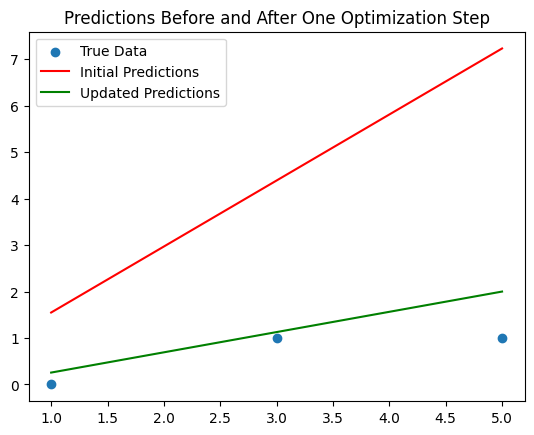

In [ ]:

# The optimizer uses the computed gradients (stored in param.grad)
# to update the model's parameters.
# The update rule for basic SGD is: new_weight = old_weight - learning_rate * gradient
optimizer.step()

print("\n--- Model Parameters After Optimizer Step ---")
print(f"Updated weights (fc1.weight): {model.fc1.weight.data}")
print(f"Updated bias (fc1.bias): {model.fc1.bias.data}")

# For verification, let's do another forward pass with the updated weights
# and see if the loss has decreased (it should, for a well-behaved problem).
with torch.no_grad(): # Disable gradient tracking for this verification forward pass
    new_predictions = model(X)
    new_loss = criterion(new_predictions, y_true)
print(f"\nLoss after one optimization step: {new_loss.item():.4f}")


# Initial Loss: [loss.item() from Step 4]
# Loss After 1 Step: [new_loss.item() from Step 6]

# If plotting library was available and X was 1D:
import matplotlib.pyplot as plt
plt.scatter(X.numpy()[:, 0], y_true.numpy(), label='True Data')
plt.plot(X.numpy()[:, 0], predictions.detach().numpy(), color='red', label='Initial Predictions')
plt.plot(X.numpy()[:, 0], new_predictions.detach().numpy(), color='green', label='Updated Predictions')
plt.legend()
plt.title('Predictions Before and After One Optimization Step')
plt.show()